# **Welcome to my Notebook**
Made by Jundan Saiful Haq for DSAI Recruitment.

In this notebook, here, i will do an Airbnb price prediction which is useful for tourists who want to find the best accommodation according to their version and their capabilities.

# 1. Import some libraries, read the CSV, and merge the data

Import the common libraries first, and then read each csv files and convert into data frame. And save the test id's so that we can make submission from id's that we save

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
traindf = pd.read_csv("sample_data/train.csv")
airbnbdf = pd.read_csv("sample_data/airbnb.csv")
hostdf = pd.read_csv("sample_data/host.csv")
commentdf = pd.read_csv("sample_data/comment.csv")
reviewdf = pd.read_csv("sample_data/review.csv")
testdf = pd.read_csv("sample_data/test.csv")

# 2. EDA (Exploration Data Analysis)

In this section, we will investigate the data statistics, like five first data (df.head), our data statistics (df.describe) and the price distribution before log transformation.

Shape raw data
Train data: (2954, 2)
Test data: (739, 1)
Airbnb data: (3693, 24)

Sample data (train):

Desctiptive statistics (target):


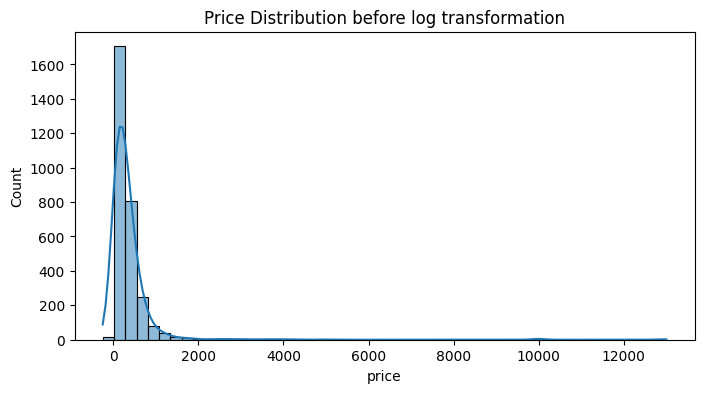

In [86]:
print("Shape raw data")
print(f"Train data: {traindf.shape}")
print(f"Test data: {testdf.shape}")
print(f"Airbnb data: {airbnbdf.shape}")

print("\nSample data (train):")
traindf.head()

print("\nDesctiptive statistics (target):")
traindf['price'].describe()

plt.figure(figsize=(8,4))
sns.histplot(traindf['price'], bins=50, kde=True)
plt.title("Price Distribution before log transformation")
plt.show()

**Feature Engineering (Row-wise Operations)**

Make a function to calculate the sentiment, the function of this sentiment is to find out, is text is a negative, positive, or netral.

In [87]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isnull(text): return 0
    return sia.polarity_scores(text)['compound']

commentdf['sentiment_score'] = commentdf['comments'].apply(get_sentiment)

comment_features = commentdf.groupby('id')['sentiment_score'].agg(['mean', 'count']).reset_index()
comment_features.columns = ['id', 'sentiment_mean', 'review_count']

The next step is parsing the amenities. This function is to count how many expensive facility that they have

In [88]:
def parse_amenities(row):
    row = str(row).lower()
    has_pool = 1 if 'pool' in row else 0
    has_wifi = 1 if 'wifi' in row else 0
    has_ac = 1 if 'air conditioning' in row else 0
    has_gym = 1 if 'gym' in row else 0
    has_kitchen = 1 if 'kitchen' in row else 0
    count = row.count(',') + 1
    return pd.Series([has_pool, has_wifi, has_ac, has_gym, has_kitchen, count])

airbnbdf[['has_pool', 'has_wifi', 'has_ac', 'has_gym', 'has_kitchen', 'amenities_count']] = airbnbdf['amenities'].apply(parse_amenities)

After we get the sentiment score and the amenities that might be expensive, now we will merge the all data that we have before.

In [89]:
def merge_all(main_df):
    df = pd.merge(main_df, airbnbdf, on='id', how='left')
    df = pd.merge(df, hostdf, on='id', how='left')
    df = pd.merge(df, reviewdf, on='id', how='left')
    df = pd.merge(df, comment_features, on='id', how='left')
    return df

train_merged = merge_all(traindf)
test_merged = merge_all(testdf)

In this cell, we will check the data after merge it all

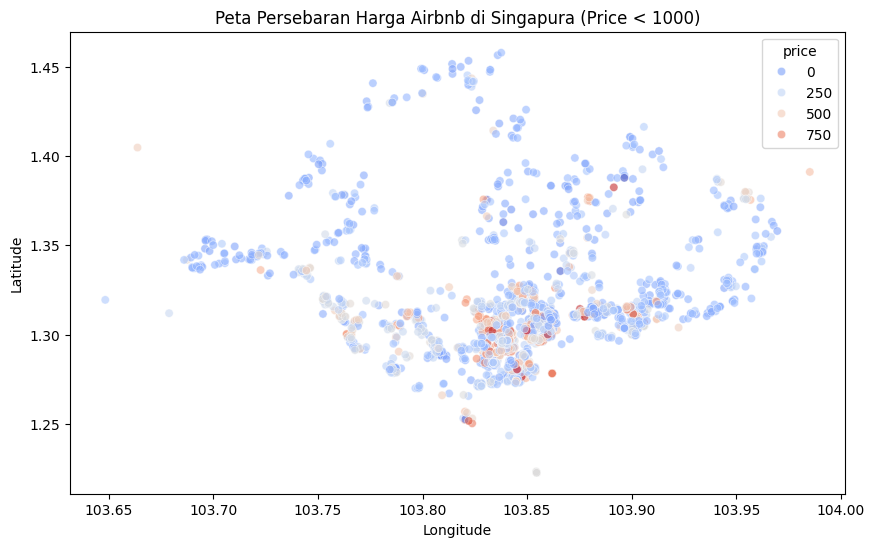

In [ ]:
plt.figure(figsize=(10, 6))
subset_map = train_merged[train_merged['price'] < 1000]

sns.scatterplot(
    data=subset_map, 
    x='longitude', 
    y='latitude', 
    hue='price', 
    palette='coolwarm', 
    alpha=0.6
)
plt.title("Distribution of the Airbnb in the Singapore (Price < 1000)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

From the visualization above, we can see that latitude and longitude affect the price. The place with latitude around 103.75-103.90 and altitude around 1.25-1.35 has a relatively high price because of its more strategic location in Singapore

                    id  price  \
0   840338886577189778   88.0   
1             25963531   76.0   
2             15813099  202.0   
3  1159877277633034540  531.0   
4   630126688219312259  345.0   

                                                name  \
0                   Private room w/ private bathroom   
1  AweSome view* Ensuite 1+1 @ City (Not For Tour...   
2              Newton -few minutes from Orchard Road   
3                                 Superior Twin Room   
4             Modern 3 BR Walking To Viva Vista Mall   

                                         description  \
0  Room comes w/ a comfy queen size bed, a built-...   
1  1. Private living room space with cable-TV and...   
2  A cosy charming British townhouse with 3 color...   
3  Located on the east side of Singapore. Changi ...   
4  This modern apartment is located in Queenstown...   

                               neighborhood_overview  \
0                                                NaN   
1  - Apartment 

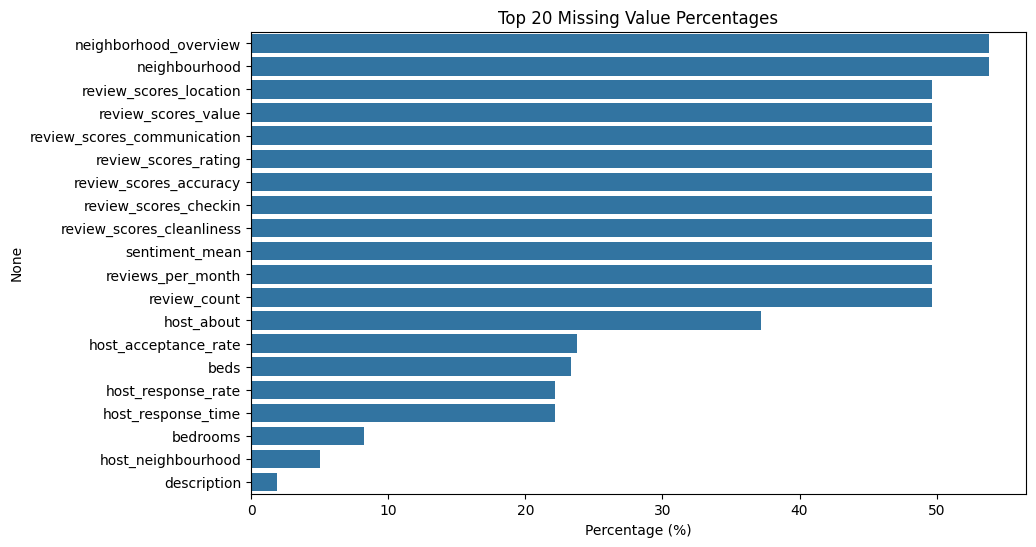


Correlation of the features with the price:
price                1.000000
accommodates         0.115467
has_gym              0.083294
id                   0.079569
bedrooms             0.076011
availability_90      0.064843
availability_60      0.064373
availability_30      0.061871
beds                 0.059674
reviews_per_month    0.058076
Name: price, dtype: float64


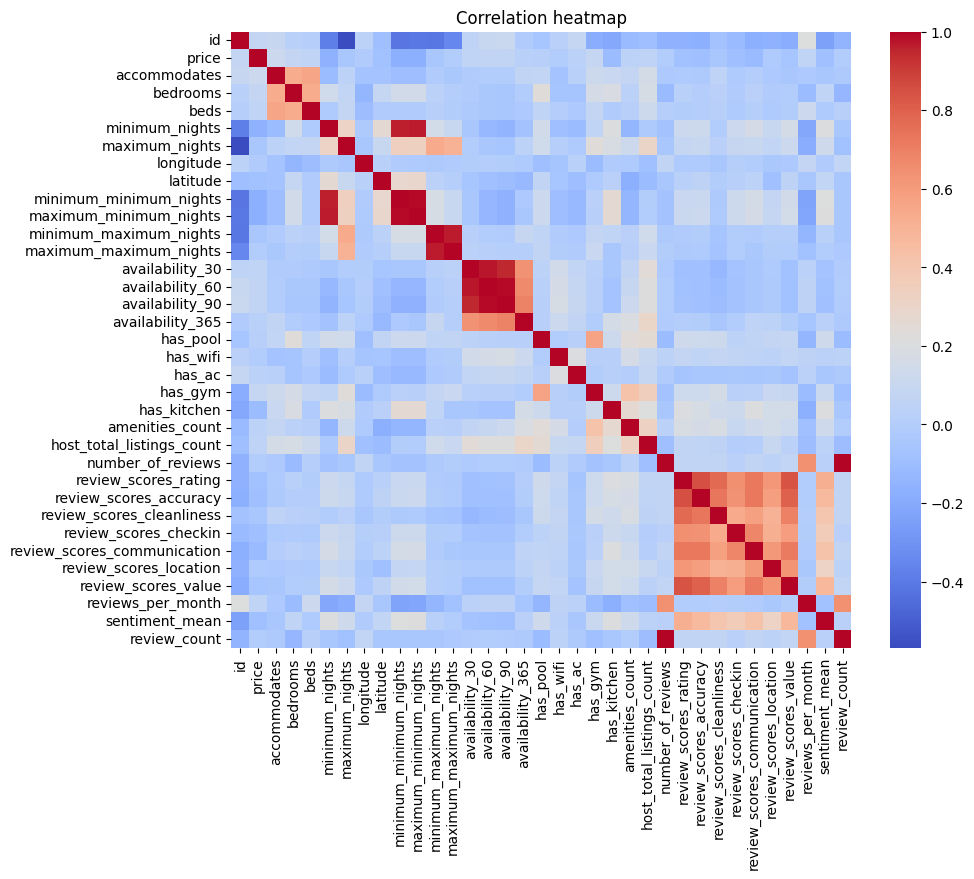

In [90]:
print(train_merged.head())
print("\nData info after merging:")
train_merged.info()

print("\nMissing values in train data:")
print(train_merged.isnull().sum())
missing_percent = (train_merged.isnull().sum() / len(train_merged)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

print("\nMissing value percentages:")
print(missing_percent.head(10))

print("\nVisualizing missing values:")
plt.figure(figsize=(10,6))
sns.barplot(x=missing_percent.head(20).values, y=missing_percent.head(20).index)
plt.title("Top 20 Missing Value Percentages")
plt.xlabel("Percentage (%)")
plt.show()

print("\nCorrelation of the features with the price:")
numeric_corr = train_merged.select_dtypes(include=[np.number]).corr()
print(numeric_corr['price'].sort_values(ascending=False).head(10))

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_corr, cmap='coolwarm', annot=False)
plt.title("Correlation heatmap")
plt.show()

# 3. PreProcessing Data

In this section, we'd like to repair data, drop data and clean data. In this data, there are so many missing values, and we have to fix that feature. We have to find the duplicate data, outlier, and data anomalies too.

After we merge all the datasets, we will drop the raw teks that's not used anymore

In [91]:
cols_to_drop = ['name', 'description', 'neighborhood_overview', 'host_about', 
                'amenities', 'host_verifications', 'host_name', 'listing_url', 
                'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url']

In [92]:
train_merged = train_merged.drop(columns=cols_to_drop, errors='ignore')
test_merged = test_merged.drop(columns=cols_to_drop, errors='ignore')

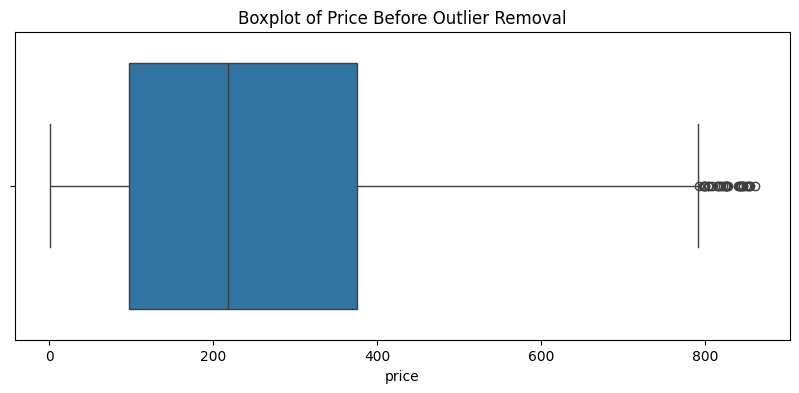

Price Statistics Before Outlier removal:
count    2788.000000
mean      260.442287
std       192.551565
min         1.000000
25%        97.193245
50%       217.523635
75%       375.000000
max       860.347530
Name: price, dtype: float64


In [114]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_merged['price'])
plt.title("Boxplot of Price Before Outlier Removal")
plt.show()

print("Price Statistics Before Outlier removal:")
print(train_merged['price'].describe())

You can see that there are so many outlier in the train dataset

For the outlier data, we will remove the data that above upper limit and under lower limit. To determine the upper limit and lower limit of our data, we will use the IQR method. IQR is the distance between the third quartile (Q3) and the first quartile (Q1)

$IQR = Q_3 - Q_1$

To determine our upper limit and bottom limit, we can use this method:

Upper limit formula:

$\text{Upper Limit} = Q_3 + (1.5 \cdot IQR)$


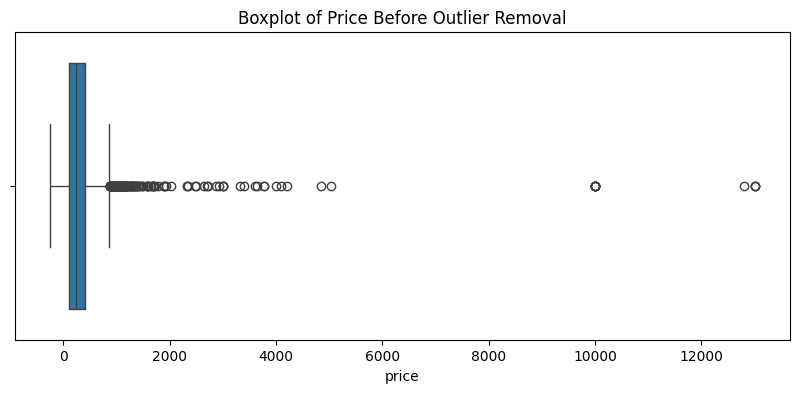

Price Statistics Before Outlier removal:
count     2954.000000
mean       361.547223
std        764.335605
min       -248.748230
25%        100.000000
50%        232.000000
75%        405.788150
max      13000.000000
Name: price, dtype: float64

Data cleanded from 2954 to 2788 rows.
Removed: 166 data outlier.


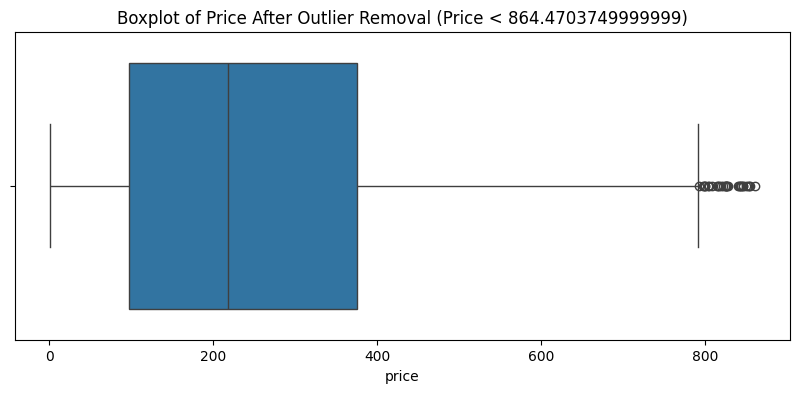

In [ ]:
Q1 = train_merged['price'].quantile(0.25)
Q3 = train_merged['price'].quantile(0.75)

IQR = Q3 - Q1
upper_limit = Q3 + (1.5 * IQR)
lower_limit = 0

original_count = len(train_merged)
train_merged = train_merged[
    (train_merged['price'] > lower_limit) & 
    (train_merged['price'] < upper_limit)
]
cleaned_count = len(train_merged)

print(f"\nData cleanded from {original_count} to {cleaned_count} rows.")
print(f"Removed: {original_count - cleaned_count} data outlier.")

plt.figure(figsize=(10, 4))
sns.boxplot(x=train_merged['price'])
plt.title(f"Boxplot of Price After Outlier Removal (Price < {upper_limit})")
plt.show()

Identificate the numeric and categorical columns to make it easier while encoding the feature.

In [93]:
numeric_cols = train_merged.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_merged.select_dtypes(include=['object']).columns.tolist()

Remove price and id columns from imputation list

In [94]:
numeric_cols = [c for c in numeric_cols if c not in ['price', 'id']]

**Numerical imputation**

Numerical imputation only from the train. Fill train and test using mean from train

In [95]:
train_medians = train_merged[numeric_cols].median()

train_merged[numeric_cols] = train_merged[numeric_cols].fillna(train_medians)
test_merged[numeric_cols] = test_merged[numeric_cols].fillna(train_medians)

**Categorical Imputation**

Fill the missing values with the unknown

In [96]:
for col in categorical_cols:
    train_merged[col] = train_merged[col].fillna('Unknown')
    test_merged[col] = test_merged[col].fillna('Unknown')

Give mark to the row

In [97]:
train_merged['is_train'] = 1
test_merged['is_train'] = 0
test_merged['price'] = 0

Merge to encode the category values and apply One Hot Encoding

In [98]:
combined = pd.concat([train_merged, test_merged], axis=0)
combined = pd.get_dummies(combined, columns=categorical_cols, drop_first=True)

train_final = combined[combined['is_train'] == 1].drop(columns=['is_train'])
test_final = combined[combined['is_train'] == 0].drop(columns=['is_train', 'price'])

That's all for the PreProcessing step, we will continue to our next step.

# 4. Modeling

In this step, this is how we train our model from dataframe that we have modifed before. In this step, we will use some models. Here, I want ensemble some model like XGBoost, LightGBM, and CatBoost.

Before we starts the modeling, we must prepare for the x and y. And we will use the log transform method to the price so that the distribution can be normal

In [100]:
y = np.log1p(train_final['price'])
x = train_final.drop(columns=['price', 'id'])
x_test_submit = test_final.drop(columns=['id'])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

Now, we will start the modeling using ensemble of some models, like XGBoost, lightgbm, and catboost.

**1. XGBoost Model**

In [101]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

model_xgb.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=100)
pred_xgb_val = model_xgb.predict(x_val)
pred_xgb_test = model_xgb.predict(x_test_submit)

[0]	validation_0-rmse:0.92554
[100]	validation_0-rmse:0.44161
[200]	validation_0-rmse:0.42476
[300]	validation_0-rmse:0.41911
[400]	validation_0-rmse:0.41706
[440]	validation_0-rmse:0.41773


**2. LightGBM Model**

Before we start the lightGBM modeling, we must clean the weird character into underscore. We should do this because lightGBM is sensitive about this

In [118]:
import re

def clean_column_names(df):
    new_columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    df.columns = new_columns
    return df

x_train = clean_column_names(x_train)
x_val = clean_column_names(x_val)
x_test_submit = clean_column_names(x_test_submit)

In [103]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(
    n_estimators=2000, 
    learning_rate=0.03, 
    max_depth=8, 
    subsample=0.7, 
    colsample_bytree=0.7, 
    n_jobs=-1, 
    random_state=42, 
    verbose=-1
)

model_lgb.fit(
    x_train, y_train, 
    eval_set=[(x_val, y_val)], 
    eval_metric='rmse', 
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

pred_lgb_val = model_lgb.predict(x_val)
pred_lgb_test = model_lgb.predict(x_test_submit)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[576]	valid_0's rmse: 0.452467	valid_0's l2: 0.204727


**3. CatBoost Model**

In [104]:
import catboost as cb
model_cb = cb.CatBoostRegressor(n_estimators=2000, learning_rate=0.03, depth=7, subsample=0.7, colsample_bylevel=0.7, random_seed=42, verbose=0, allow_writing_files=False)

model_cb.fit(x_train, y_train, eval_set=(x_val, y_val), early_stopping_rounds=50)
pred_cb_val = model_cb.predict(x_val)
pred_cb_test = model_cb.predict(x_test_submit)

# 5. Model Evaluation

In this last of our section, we're gonna evaluate the model that we have used to predict. Here, we will calculate the error of our models using sklearn.metrics method. I'm using Root Mean Squared Error (RMSE) here.

In [105]:
final_log_val = (0.4 * pred_xgb_val) + (0.3 * pred_lgb_val) + (0.3 * pred_cb_val)

In [106]:
from sklearn.metrics import mean_squared_error

In [107]:
rmse_xgb = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(pred_xgb_val)))
rmse_lgb = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(pred_lgb_val)))
rmse_cb = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(pred_cb_val)))
rmse_blend = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(final_log_val)))

print(f"\nValidation RMSE Results:")
print(f"XGBoost Alone : {rmse_xgb:.4f}")
print(f"LightGBM Alone: {rmse_lgb:.4f}")
print(f"CatBoost Alone: {rmse_cb:.4f}")

print(f"Ensemble Blend: {rmse_blend:.4f}")


Validation RMSE Results:
XGBoost Alone : 474.5305
LightGBM Alone: 689.5105
CatBoost Alone: 489.8758
Ensemble Blend: 574.7679


Since the lihgtGBM model have the most of the rmse value, in the final prediction, we'll only use XGBoost and CatBoost

In [ ]:
final_log_test = (0.5 * pred_xgb_test) + (0.5 * pred_cb_test)

final_preds_real = np.expm1(final_log_test)

submission = pd.DataFrame({
    'id': testdf['id'],
    'price': final_preds_real
})

submission.to_csv("sample_data/submission/submission8.csv", index=False)

And lastly, i visualized the diagram of Actual Train Price vs Predicted Test Price

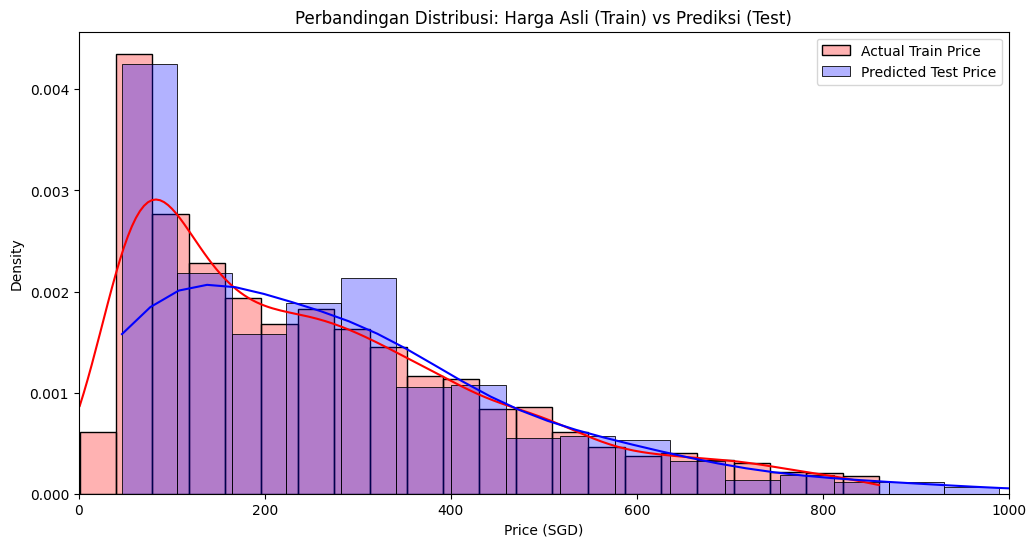

Statistik Prediksi:
count     739.000000
mean      291.806580
std       334.805811
min        46.466321
25%       105.161778
50%       245.462844
75%       373.025751
max      6116.444963
Name: price, dtype: float64


In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(train_merged['price'], kde=True, color='red', label='Actual Train Price', stat="density", alpha=0.3)
sns.histplot(submission['price'], kde=True, color='blue', label='Predicted Test Price', stat="density", alpha=0.3)

plt.title("Distribution Comparison of Actual Train Price vs Predicted Test Price")
plt.xlabel("Price (SGD)")
plt.ylabel("Density")
plt.legend()
plt.xlim(0, 1000)
plt.show()

# So thats all from my process and step by step about how we predicted the price of the Airbnb in Singapore with some datasets

In this notebook we're done for make prediction about Airbnb prices in Singapore. 
We trained and ensembled three models, XGBoost, lightGBM and CatBoost.
The evaluation metrics showed that ensembled XGBoost and CatBoost performed better than All of three models ensembled, so it was used as the final model.

Using this model, we generated price predictions for the test data and created the final submission file.

And yeah... So that's from me, I apologize if there are still many mistakes in this notebook, however I am still new to learning about data science, so I hope my mistakes can be understood.

Sayonara